### Feature Engineering dan Modelling 
- Encoding, scaling, training, hyperparameter tuning, evaluating, dan save model

In [244]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,VotingRegressor,StackingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error
import optuna
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
sys.path.append(r'c:\\Users\\Sanju\\OneDrive\\Documents\\DataScientist\\3-PORTOFOLIO\\TrenHargaRumah')
from src.utils import hist_box_plot, bar_plot, heatmap, cramers_v,violin_plot,scatter_plot

In [245]:
df = pd.read_csv("..//data//clean.csv")
df.head()

,lokasi,harga,jenis_properti,jumlah_kamar_tidur,jumlah_kamar_mandi,garasi,luas_tanah,luas_bangunan,total_ruangan
0,"Medan Johor, Medan",21.639557,Ruko,0.0,3.0,0.0,4.174387,5.351858,1.386294
1,"Medan Maimun, Medan",20.863028,Ruko,0.0,4.0,0.0,4.290459,5.262690,1.609438
2,"Medan Tembung, Medan",20.617905,Rumah,2.0,3.0,1.0,4.043051,4.615121,1.945910
3,"Medan Baru, Medan",22.031599,Rumah,5.0,5.0,2.0,5.860786,5.707110,2.564949
4,"Medan Timur, Medan",21.752885,Ruko,0.0,1.0,0.0,4.624973,5.590987,0.693147


In [246]:
X = df.drop('harga',axis=1)
y = df['harga']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2, random_state=42)
def generate_pipeline(model = None):
    transformers = ColumnTransformer([
        ('scaler',StandardScaler(),['jumlah_kamar_tidur','jumlah_kamar_mandi','garasi','luas_tanah','luas_bangunan','total_ruangan']),
        # ('one_hot',OneHotEncoder(),['lokasi','jenis_properti'])
        ('target_enc', TargetEncoder(cols=['lokasi', 'jenis_properti']), ['lokasi', 'jenis_properti'])

        # ('one_hot',OneHotEncoder(),['lokasi'])
    ])
    pipeline = Pipeline([
        ('transformer', transformers),
        ('model', model)
    ])
    return pipeline

lin_reg = generate_pipeline(LinearRegression())
lin_reg.fit(X_train,y_train)

,steps,"[('transformer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('target_enc', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [247]:
models = {
    'lin_reg': LinearRegression(),
    'svm' : SVR(),
    'rf' : RandomForestRegressor(random_state=42),
    'xgb' : XGBRegressor(random_state=42)
}

for name,model in models.items():
    pipeline = generate_pipeline(model)
    score = cross_val_score(pipeline,X_train,y_train,cv=5,scoring='r2')
    print(f"{name}: {score}")
    print(f"    rata-rata: {np.mean(score)}")

lin_reg: [0.62811861 0.65901715 0.63085543 0.67083625 0.61806088]
    rata-rata: 0.6413776608365749
svm: [0.59550922 0.63044575 0.62078087 0.64734176 0.6036115 ]
    rata-rata: 0.6195378175959985
rf: [0.75797201 0.76715719 0.72924642 0.76852016 0.7343306 ]
    rata-rata: 0.7514452756935978
xgb: [0.73603687 0.75399196 0.71660107 0.75857194 0.71966209]
    rata-rata: 0.7369727866880158


In [248]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    pipeline = generate_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f'Best params : {study.best_params}')
print(f'Best R2 (CV): {study.best_value}')

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)  # max_depth biasanya 3-20 untuk xgb
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)  # learning rate penting untuk xgb
    subsample = trial.suggest_float('subsample', 0.5, 1.0)  # untuk menghindari overfitting
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        verbosity=0,
        use_label_encoder=False
    )
    
    pipeline = generate_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    return np.mean(scores)

study2 = optuna.create_study(direction='maximize')
study2.optimize(objective, n_trials=100)

print(f'Best params : {study2.best_params}')
print(f'Best R2 (CV): {study2.best_value}')

def objective_svr(trial):
    # Hyperparameter SVR
    C = trial.suggest_float('C', 0.1, 100.0, log=True)
    epsilon = trial.suggest_float('epsilon', 0.001, 1.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = 3  # default degree untuk poly kernel
    
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
    else:
        degree = 3  # fixed jika bukan poly

    model = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree)

    pipeline = generate_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    return np.mean(scores)

study3 = optuna.create_study(direction='maximize')
study3.optimize(objective_svr, n_trials=50)

print(f'Best SVR params: {study3.best_params}')
print(f'Best SVR R2 (CV): {study3.best_value}')

[I 2025-06-19 08:16:17,340] A new study created in memory with name: no-name-52882446-f497-4f38-adae-f1344e8d8efa
[I 2025-06-19 08:16:27,070] Trial 0 finished with value: 0.7340437112258924 and parameters: {'n_estimators': 92, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7340437112258924.
[I 2025-06-19 08:16:30,629] Trial 1 finished with value: 0.750210789887156 and parameters: {'n_estimators': 98, 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.750210789887156.
[I 2025-06-19 08:16:31,761] Trial 2 finished with value: 0.71443990891907 and parameters: {'n_estimators': 190, 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.750210789887156.
[I 2025-06-19 08:16:33,166] Trial 3 finished with value: 0.7475046691277235 and parameters: {'n_estimators': 159, 'max_depth': 13, 'max_feat

Best params : {'n_estimators': 165, 'max_depth': 19, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 1}
Best R2 (CV): 0.7571365587630516


[I 2025-06-19 08:18:20,660] Trial 0 finished with value: 0.7562539752046212 and parameters: {'n_estimators': 141, 'max_depth': 19, 'learning_rate': 0.02466418756765278, 'subsample': 0.6168089773910901, 'colsample_bytree': 0.8261159056710524}. Best is trial 0 with value: 0.7562539752046212.
[I 2025-06-19 08:18:25,427] Trial 1 finished with value: 0.7147955816909295 and parameters: {'n_estimators': 119, 'max_depth': 18, 'learning_rate': 0.01571834313841967, 'subsample': 0.5864736195373432, 'colsample_bytree': 0.6699821581818258}. Best is trial 0 with value: 0.7562539752046212.
[I 2025-06-19 08:18:26,025] Trial 2 finished with value: 0.7288053113125719 and parameters: {'n_estimators': 84, 'max_depth': 6, 'learning_rate': 0.2975629568515461, 'subsample': 0.7693668505988052, 'colsample_bytree': 0.5437376962201574}. Best is trial 0 with value: 0.7562539752046212.
[I 2025-06-19 08:18:37,703] Trial 3 finished with value: 0.7515740127223418 and parameters: {'n_estimators': 176, 'max_depth': 19,

Best params : {'n_estimators': 98, 'max_depth': 15, 'learning_rate': 0.0449825034277912, 'subsample': 0.8908043963071053, 'colsample_bytree': 0.7035597728099754}
Best R2 (CV): 0.760055104472176


[I 2025-06-19 08:25:42,255] Trial 0 finished with value: 0.6459329364035579 and parameters: {'C': 7.5342157108743955, 'epsilon': 0.03087225047014036, 'kernel': 'poly', 'degree': 2}. Best is trial 0 with value: 0.6459329364035579.
[I 2025-06-19 08:25:47,041] Trial 1 finished with value: 0.6398809389754632 and parameters: {'C': 0.12194170357382801, 'epsilon': 0.0010076644692775486, 'kernel': 'linear'}. Best is trial 0 with value: 0.6459329364035579.
[I 2025-06-19 08:25:49,261] Trial 2 finished with value: 0.65947073920913 and parameters: {'C': 50.2229975086662, 'epsilon': 0.002630893347477566, 'kernel': 'poly', 'degree': 3}. Best is trial 2 with value: 0.65947073920913.
[I 2025-06-19 08:25:51,906] Trial 3 finished with value: -3.122481827595433 and parameters: {'C': 11.114607967711132, 'epsilon': 0.012682222980203573, 'kernel': 'sigmoid'}. Best is trial 2 with value: 0.65947073920913.
[I 2025-06-19 08:25:54,653] Trial 4 finished with value: 0.5586323569557435 and parameters: {'C': 0.1723

Best SVR params: {'C': 98.86711295844484, 'epsilon': 0.014848574235272124, 'kernel': 'poly', 'degree': 5}
Best SVR R2 (CV): 0.667930090933854


In [249]:
estimators = [
    ('rf', RandomForestRegressor(**study.best_params)),
    ('xgb', XGBRegressor(**study2.best_params)),
    ('svr', SVR(**study3.best_params))
]
stack = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
pipeline = generate_pipeline(stack)

pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

0.6782859580870191


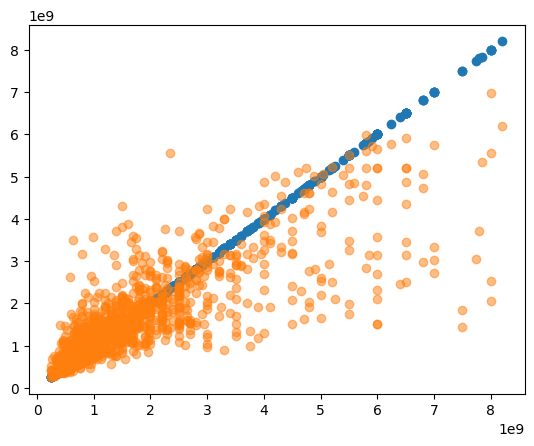

In [250]:
plt.scatter(np.expm1(y_test),np.expm1(y_test),alpha=1)
plt.scatter(np.expm1(y_test),np.expm1(y_pred),alpha=.5)
print(r2_score(y_pred,y_test))

R2-Score Apartemen: 0.8376254466099062


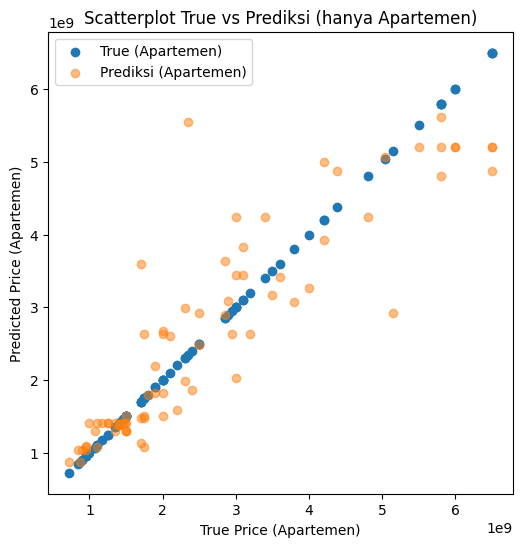

In [251]:
mask_apartemen = X_test['jenis_properti'] == 'Apartemen'

y_test_apartemen = y_test[mask_apartemen]
y_pred_apartemen = y_pred[mask_apartemen]

print(f"R2-Score Apartemen: {r2_score(y_test_apartemen,y_pred_apartemen)}")
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(y_test_apartemen), np.expm1(y_test_apartemen), alpha=1, label="True (Apartemen)")
plt.scatter(np.expm1(y_test_apartemen), np.expm1(y_pred_apartemen), alpha=0.5, label="Prediksi (Apartemen)")
plt.xlabel('True Price (Apartemen)')
plt.ylabel('Predicted Price (Apartemen)')
plt.legend()
plt.title("Scatterplot True vs Prediksi (hanya Apartemen)")
plt.show()


R2-Score Rumah: 0.7701101871229052


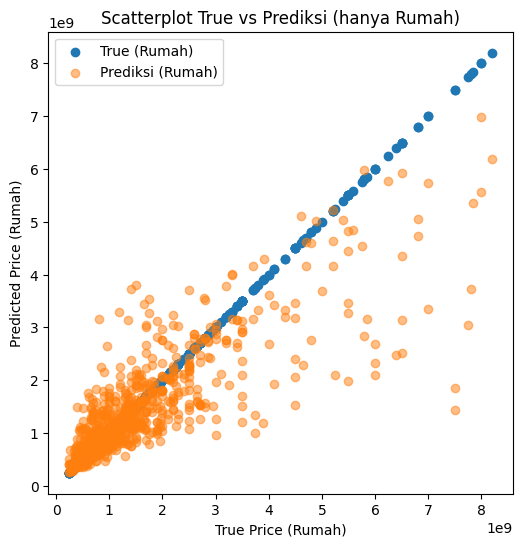

In [252]:
mask_Rumah = X_test['jenis_properti'] == 'Rumah'

y_test_Rumah = y_test[mask_Rumah]
y_pred_Rumah = y_pred[mask_Rumah]

print(f"R2-Score Rumah: {r2_score(y_test_Rumah,y_pred_Rumah)}")
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(y_test_Rumah), np.expm1(y_test_Rumah), alpha=1, label="True (Rumah)")
plt.scatter(np.expm1(y_test_Rumah), np.expm1(y_pred_Rumah), alpha=0.5, label="Prediksi (Rumah)")
plt.xlabel('True Price (Rumah)')
plt.ylabel('Predicted Price (Rumah)')
plt.legend()
plt.title("Scatterplot True vs Prediksi (hanya Rumah)")
plt.show()


R2-Score Ruko: 0.5149591229813519


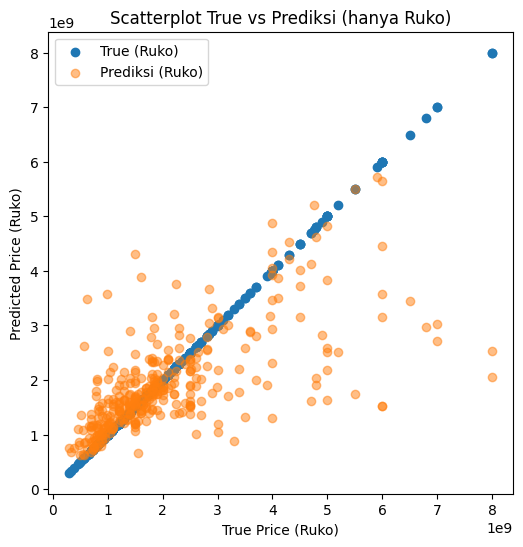

In [253]:
mask_Ruko = X_test['jenis_properti'] == 'Ruko'

y_test_Ruko = y_test[mask_Ruko]
y_pred_Ruko = y_pred[mask_Ruko]

print(f"R2-Score Ruko: {r2_score(y_test_Ruko,y_pred_Ruko)}")
plt.figure(figsize=(6,6))
plt.scatter(np.expm1(y_test_Ruko), np.expm1(y_test_Ruko), alpha=1, label="True (Ruko)")
plt.scatter(np.expm1(y_test_Ruko), np.expm1(y_pred_Ruko), alpha=0.5, label="Prediksi (Ruko)")
plt.xlabel('True Price (Ruko)')
plt.ylabel('Predicted Price (Ruko)')
plt.legend()
plt.title("Scatterplot True vs Prediksi (hanya Ruko)")
plt.show()


### MAE dan RMSE

In [254]:
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

print(f"MAE: {mean_absolute_error(y_test_exp, y_pred_exp)}")
print(f"RMSE: {root_mean_squared_error(y_test_exp, y_pred_exp)}")

MAE: 423489775.2361355
RMSE: 812222658.3996226


In [255]:
mae = mean_absolute_error(y_test_exp, y_pred_exp)
rmse = root_mean_squared_error(y_test_exp, y_pred_exp)

# Hitung rata-rata harga asli sebagai pembanding
mean_price = np.mean(y_test_exp)

# Normalisasi error terhadap rata-rata harga (relatif error)
mae_relative = mae / mean_price
rmse_relative = rmse / mean_price

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Mean Price: {mean_price:.2f}")
print(f"Relative MAE: {mae_relative:.2%}")
print(f"Relative RMSE: {rmse_relative:.2%}")


MAE: 423489775.24
RMSE: 812222658.40
Mean Price: 1596862615.59
Relative MAE: 26.52%
Relative RMSE: 50.86%


In [256]:
import joblib

joblib.dump(voting_reg,"..//model//stacking_pipeline.pkl")

['..//model//stacking_pipeline.pkl']

## Insight dan Summary
- Penggunaan pipeline untuk kemudahan dalam preprocessing, training dan prediksi
- Menggunakan Stacking Regressor dengan model XGB, Random Forest, dan SVR yang sudah di hyperparameter tuning dengan optuna untuk mencari hyperparameter optimal
- Setelah evaluasi, untuk model XGBoost, skor yang didapat yakni:
    - MAE: 423489775.24
    - RMSE: 812222658.40
    - Mean Price: 1596862615.59
    - Relative MAE: 26.52%
    - Relative RMSE: 50.86%
- R2 Score untuk kategori Apartemen yang paling tinggi yakni 0.8376254466099062 lalu Rumah 0.7701101871229052 dan Ruko yang paling rendah 0.5149591229813519
- Overall, model menunjukkan hasil yang lumrah untuk dataset dengan fitur seadanya yakni hanya area/kamar/lokasi tekstual. Kedepannya model dapat ditingkatkan performanya dengan mendapatkan fitur berupa alamat lengkap, langitude longitude, umur bangunan, serta ke-strategisan (dekat ke sekolah,dsb).


In [258]:
del study
del study2
del study3

NameError: name 'study' is not defined